In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
import numpy as np
import utils

torch.manual_seed(42069)
# if gpu available else cpu
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
TRAIN_MEAN = [0.5036, 0.4719, 0.3897]
TRAIN_STD = [0.2623, 0.2577, 0.2671]
classes = ['butterfly','cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('models/results.csv')

In [3]:
session_map = {
    '20221209_195344': 'ResNet - ImgNet Weights', 
    '20221209_205319': 'ResNet - ImgNet Weights (bez normalizacji)', 
    '20221209_211433': 'ResNet - Random Weights', 
    '20221209_213015': 'AlexNet - Random Weights', 
    '20221209_215731': 'AlexNet - ImgNet Weights', 
    '20221209_230012': 'LeNet - Random Weights'
}

In [4]:
#for stat in ['loss','train_acc','test_acc']:
df.groupby('session_id').describe().loc[:, 'loss'].rename(index=session_map)

,count,mean,std,min,25%,50%,75%,max
session_id,,,,,,,,
ResNet - ImgNet Weights,5.0,0.346600,0.113944,0.271,0.2920,0.294,0.329,0.547
ResNet - ImgNet Weights (bez normalizacji),5.0,0.351800,0.120444,0.268,0.2800,0.307,0.343,0.561
ResNet - Random Weights,5.0,1.527600,0.266529,1.261,1.3550,1.465,1.615,1.942
AlexNet - Random Weights,5.0,1.980600,0.170614,1.773,1.8620,1.983,2.084,2.201
AlexNet - ImgNet Weights,5.0,0.482400,0.090969,0.409,0.4300,0.455,0.480,0.638
LeNet - Random Weights,15.0,1.886867,0.191031,1.631,1.7295,1.860,2.039,2.211


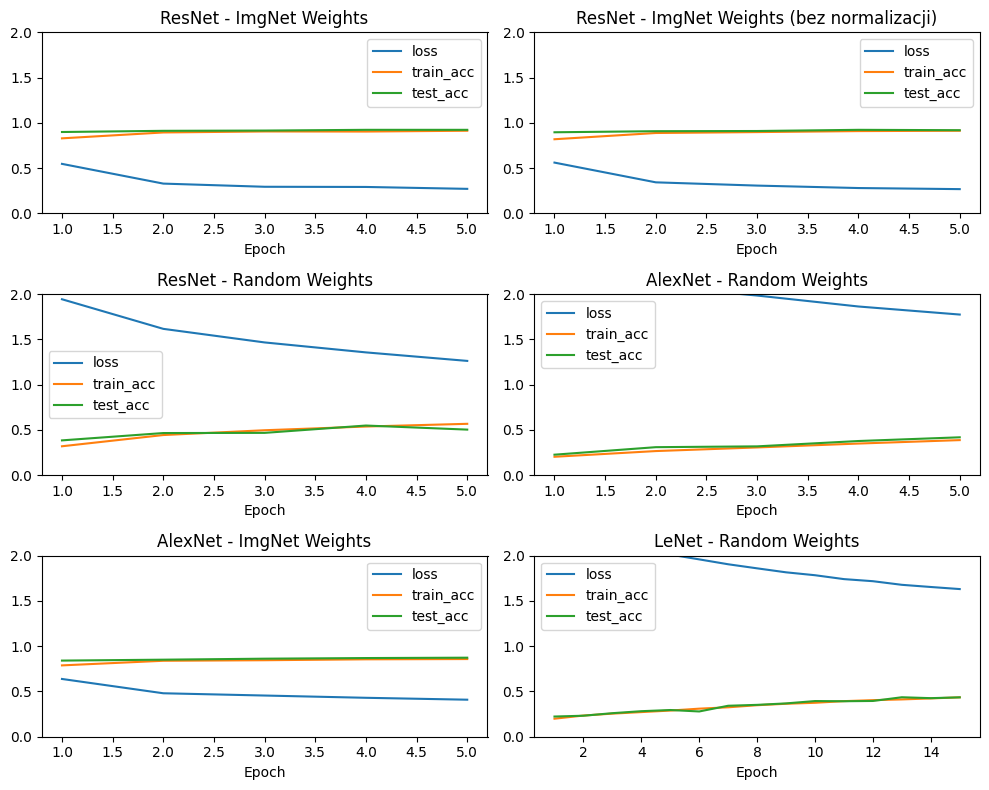

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(10,8))
# for i, session in enumerate(df.session_id.unique()):

for i in range(3):
    for j in range(2):
        session = df.session_id.unique()[2*i+j]
        ax[i, j].plot(df[df.session_id == session].epoch, df[df.session_id == session].loss)
        ax[i, j].plot(df[df.session_id == session].epoch, df[df.session_id == session].train_acc)
        ax[i, j].plot(df[df.session_id == session].epoch, df[df.session_id == session].test_acc)
        ax[i, j].set_ylim([0, 2])
        ax[i, j].set_title(session_map[session])
        ax[i, j].legend(['loss', 'train_acc', 'test_acc'])
        ax[i, j].set_xlabel('Epoch')
#fig.suptitle('Saved metrics')
fig.tight_layout()

## Wczytanie wytrenowanego modelu

In [6]:
res_net_model = resnet18()
res_net_model.fc = nn.Linear(res_net_model.fc.in_features, len(classes))
res_net_model.load_state_dict(torch.load('model_params/train20221209_195344_5'))
res_net_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# zdefiniowanie operacji na kazdym obrazie w zbiorze
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),              
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD) 
])

# loader danych z batchami
test_data = ImageFolder(root='dataset/test/', transform=transform)
batch_size = 32
test_loader = DataLoader(test_data, batch_size=batch_size)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
# again no gradients needed
with torch.no_grad():
    res_net_model.eval()
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res_net_model(images)
        _, predictions = torch.argmax(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: butterfly is 95.3 %
Accuracy for class: cat   is 89.2 %
Accuracy for class: chicken is 93.7 %
Accuracy for class: cow   is 77.1 %
Accuracy for class: dog   is 93.1 %
Accuracy for class: elephant is 93.9 %
Accuracy for class: horse is 91.2 %
Accuracy for class: sheep is 90.1 %
Accuracy for class: spider is 96.7 %
Accuracy for class: squirrel is 90.1 %


In [56]:
# zdefiniowanie operacji na kazdym obrazie w zbiorze
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),              
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD) 
])

# loader danych z batchami
test_data = ImageFolder(root='dataset/test/', transform=transform)
batch_size = 32
test_loader = DataLoader(test_data, batch_size=batch_size)

correct = 0
total = 0

all_labels = torch.tensor([], device=device)
all_predictions = torch.tensor([], device=device)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    res_net_model.eval()
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = res_net_model(images)
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, 1)

        all_labels = torch.concat([all_labels, labels], dim=0)
        all_predictions = torch.concat([all_predictions, predicted], dim=0)        

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 91 %


In [58]:
from sklearn.metrics import confusion_matrix


confusion_matrix(all_labels.cpu().numpy(),all_predictions.cpu().numpy())

array([[ 504,    1,    4,    0,    3,    0,    1,    0,   15,    0],
       [   5,  368,    1,    0,   31,    0,    0,    2,    7,    3],
       [   3,    1,  724,    1,   19,    3,    6,    1,    9,    8],
       [   0,    0,    6,  372,   18,    0,   41,   24,    4,    2],
       [   2,   17,   12,   13, 1125,    9,   18,    7,    5,    8],
       [   1,    1,    4,    2,    6,  342,    3,    1,    2,    0],
       [   4,    1,    2,   12,   18,    7,  599,    9,    4,    0],
       [   2,    5,    3,   10,    9,    8,    8,  404,    3,    3],
       [  21,    0,    4,    2,    4,    3,    2,    0, 1165,    5],
       [   4,    5,   10,    1,   11,    2,    2,    2,   10,  419]],
      dtype=int64)

In [57]:
#531+388+762+416+1283+376+658+456+1237+440
all_predictions.shape, all_labels.shape

(torch.Size([6548]), torch.Size([6548]))

In [52]:
all_labels[:32]
#total

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [55]:
torch.concat([predicted, predicted]).shape

torch.Size([40])